# La classification d'image  avec CNN

## Le Rapport 

## I : L'introduction
    Dans ce projet nous allons utilié les reseaux de neurone convolutif pour la classification des images d'une data set.

    Pour cela nous allons utilisé le dataset GTSRB (les panneaux de sirculation) qui contiens lus de 40000 images et 40 classes.

    Le but est d'entrainer un modèle pour qu'il puise reconnaitre la classe une image donnée.
    
    Les reseaux de neurone convolutif sont très efficace dans le domaine de la reconnaissance des formes.

## II: Le chargement et l'exploiration des données

    Nous allons chargé le dataset GTSRB depuis le disque local et effectué un peu de traintement avant de le faire passer au modèle.

## III: Le Pretreaiment

    Le pretraitement est une étape très importante dans le processus de classification des images.

    cette étape nous permet de netoyer le dataset en appliquant les algorithmes de traintement d'image comment le filtrage , la segmentation ...

    Nous allons crée une fonction preprocessing pour preparer un peu notre dataset.

    cette fonction prend en parametre  un dataset et retourne dataset preparé.

## IV: L'extraction des caracteristiques

    L'extraction des caracteristiques a pour but de selectionner les meilleurs caracterisques pour le modèle.

    c'est très important  de bien faire cette partie surtout si le dataset contient beaucoup de caracteristique (par exemple : à quoi sert une variable quand elle ne varie pas ?)

## V: La classification (entrenement du modèle ) et le test

    En fin la dernière partie de notre travaile est l'entrainement du modèle et après le test.

    C'est pour ça nous avons divisé le dataset en deux partie, un epour l'entrainement  et autre pour le test.

    Nous avons utilisé la librairie scikit-learning (sklearn) pour faire cette division.

    Tensorflow (le framework de machine learning ) à été utilisé  pour la creation du modèle. il est très éfficace et opensource donc beaucoup utiliser.

## VI: La conclusion


### Lechargement l'exploration des données

In [1]:
# importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.model_selection import train_test_split
import os
import pathlib
from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.filters import rank
from skimage import io, color, exposure, transform
import PIL
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, MaxPooling2D

2021-12-28 20:39:20.134438: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cs/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-28 20:39:20.134490: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#initialisation des parametre
data_dir = "GTSRB_DATASET"
train_path = "GTSRB_DATASET/Train"
test_path = "GTSRB_DATASET/Test"
IMG_HEIGTH = 30
IMG_WIDTH = 30
NUM_CATEGORIES = len(os.listdir(train_path))

Les Images originales


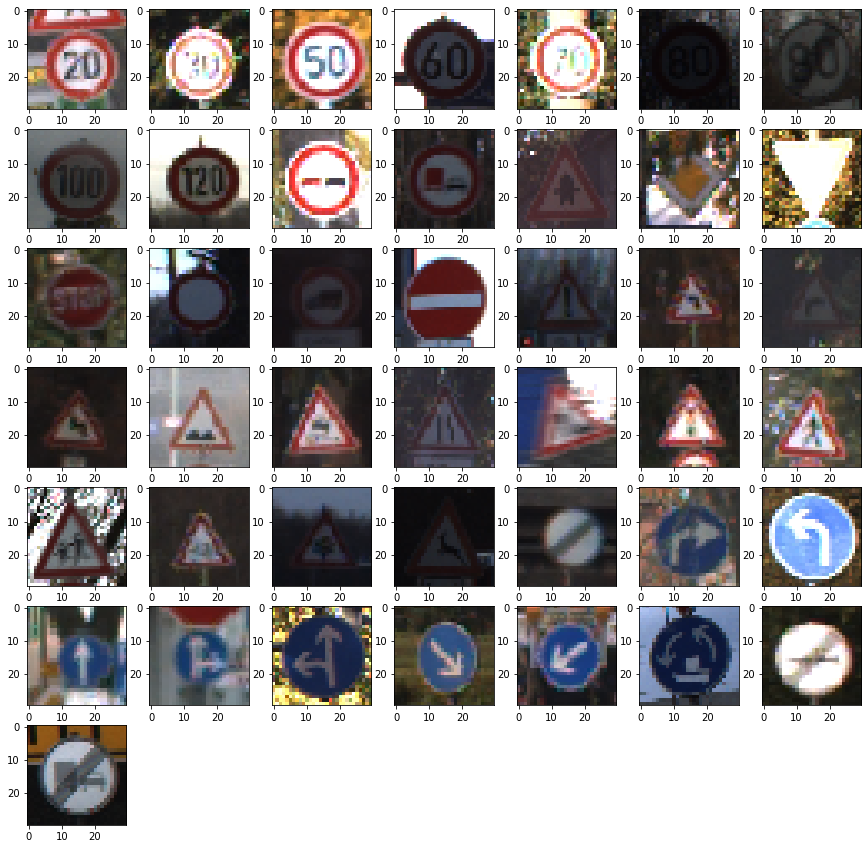

In [3]:
# Affisage de quelques images de notre dataset 
img_dir = pathlib.Path(train_path)
plt.figure(figsize=(15, 15))
print("Les Images originales")
for i in range(NUM_CATEGORIES):
    plt.subplot(7 , 7, i+1)
    sign = list(img_dir.glob(f'{i}/*'))[0]
    img = load_img(sign , target_size = (IMG_HEIGTH, IMG_WIDTH))
    plt.imshow(img)

In [4]:
# Initialisation des noms des labels (les noms des classes)
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

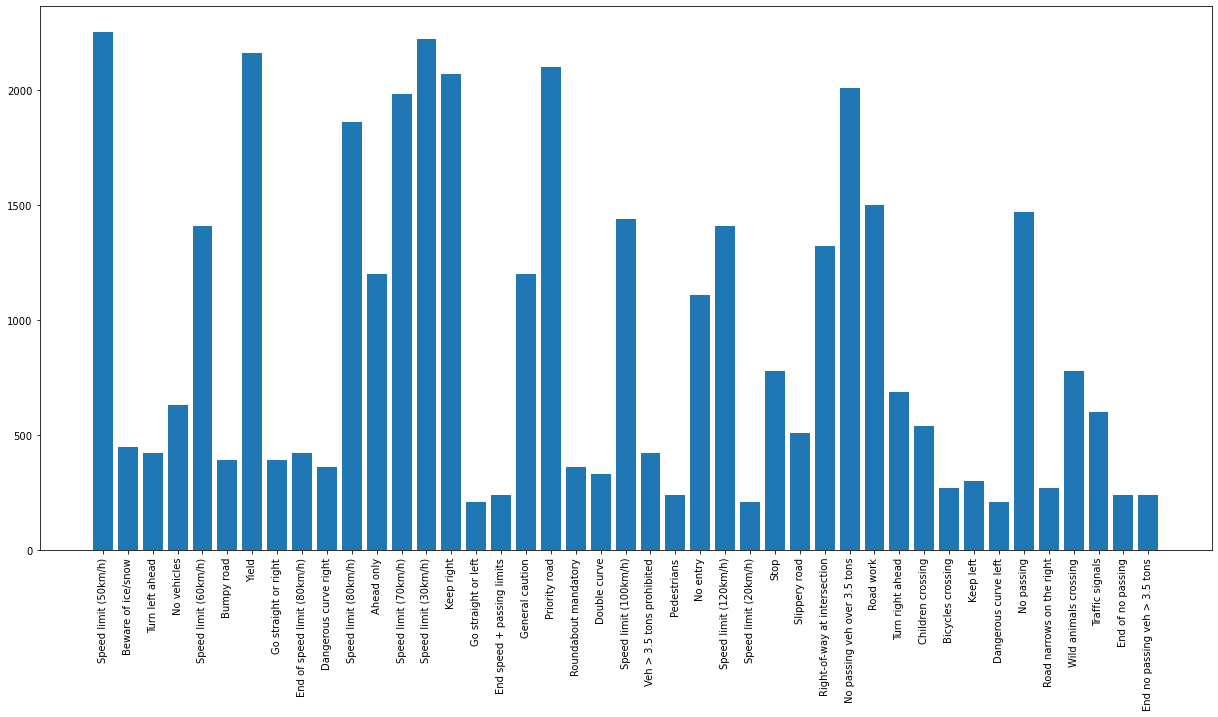

In [5]:
# La repartision des images par classe 

folders = os.listdir(train_path)

train_num = []
class_num = []

for f in folders :

    file_num = len(os.listdir(train_path + "/" + f))
    train_num.append(file_num)
    class_num.append(classes[int(f)])
    
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_num)
plt.xticks(class_num, rotation='vertical')
plt.show()


In [6]:
"""
cette fonction prend le chemin des données en parametre deux list :
images: toutes les images du dataset
labels: les classes des images .
"""
def data_loader(data_dir):
    images  = list()
    labels = list()
    for c in range(NUM_CATEGORIES):
        categories = os.path.join(data_dir , str(c))
        for img in os.listdir(categories):
            img = load_img(os.path.join(categories, img) , target_size=(30, 30))
            image = img_to_array(img)
            images.append(image) 
            labels.append(c)
    return images , labels

In [7]:
images , labels = data_loader(train_path)

In [8]:
labels = to_categorical(labels)

### Le pretraitement

#### Transformation des imges de dataset en niveau de grie et calcul de histogramme equaliser

In [23]:
def preprocessing(data):
    img_gray = list()
    for img in data:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        #img=exposure.equalize_hist(img)
        img_gray.append(img)
    return np.array(img_gray)
        
    

In [24]:
#df = pd.read_csv(f'{data_dir}/Train.csv')

In [25]:
data = preprocessing(images)

In [38]:
data.shape

(39209, 30, 30)

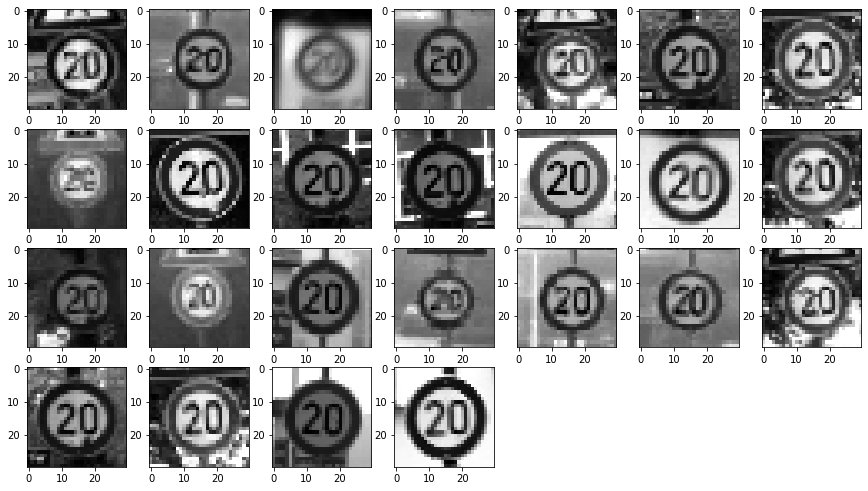

Images en niveau de gris


In [26]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(7, 7, i+1)
    plt.imshow(data[i], cmap = "gray")
plt.show()

print("Images en niveau de gris")

In [27]:
# diviser le dataset en deux base , une base d'entrainement(x_train) et une base de test (x_test)
x_train , x_test , y_train  , y_test = train_test_split(data , labels , test_size=0.3)


In [15]:
type(data)

numpy.ndarray

Normalisation

In [28]:
x_train = x_train/255
x_test = x_test/255
print(x_train.shape)
print(x_test.shape)

(27446, 30, 30)
(11763, 30, 30)


In [17]:
print(" La taille de notre base d'entrainement est ", x_train.shape[0])
print(" La taille de notre base d'entrainement est " , x_test.shape[0])

 La taille de notre base d'entrainement est  27446
 La taille de notre base d'entrainement est  11763


In [31]:
x_train = x_train.reshape(-1, 30, 30, 1)
x_test = x_test.reshape(-1, 30, 30, 1)

In [32]:
type(x_train)

numpy.ndarray

In [33]:
input_shape = (30, 30, 1)

In [34]:
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Second Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Third Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(NUM_CATEGORIES, activation='softmax'))

# Compiling the model


lr = 0.001
epochs = 30
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 6, 6, 64)         

In [36]:
history = model.fit(x_train , y_train, validation_split=0.3 , epochs = 20)
#model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

2021-12-25 23:40:20.885429: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 69163200 exceeds 10% of free system memory.


Epoch 1/20
601/601 [==============================] - 86s 143ms/step - loss: 0.1216 - accuracy: 0.9613 - val_loss: 0.0574 - val_accuracy: 0.9828
Epoch 2/20
601/601 [==============================] - 92s 153ms/step - loss: 0.0959 - accuracy: 0.9705 - val_loss: 0.0455 - val_accuracy: 0.9869
Epoch 3/20
601/601 [==============================] - 93s 154ms/step - loss: 0.0763 - accuracy: 0.9740 - val_loss: 0.0507 - val_accuracy: 0.9815
Epoch 4/20
601/601 [==============================] - 93s 155ms/step - loss: 0.0694 - accuracy: 0.9777 - val_loss: 0.0419 - val_accuracy: 0.9879
Epoch 5/20
601/601 [==============================] - 97s 161ms/step - loss: 0.0745 - accuracy: 0.9758 - val_loss: 0.0533 - val_accuracy: 0.9837
Epoch 6/20
601/601 [==============================] - 99s 165ms/step - loss: 0.0588 - accuracy: 0.9820 - val_loss: 0.0339 - val_accuracy: 0.9899
Epoch 7/20
601/601 [==============================] - 97s 162ms/step - loss: 0.0551 - accuracy: 0.9821 - val_loss: 0.0518 - val_ac

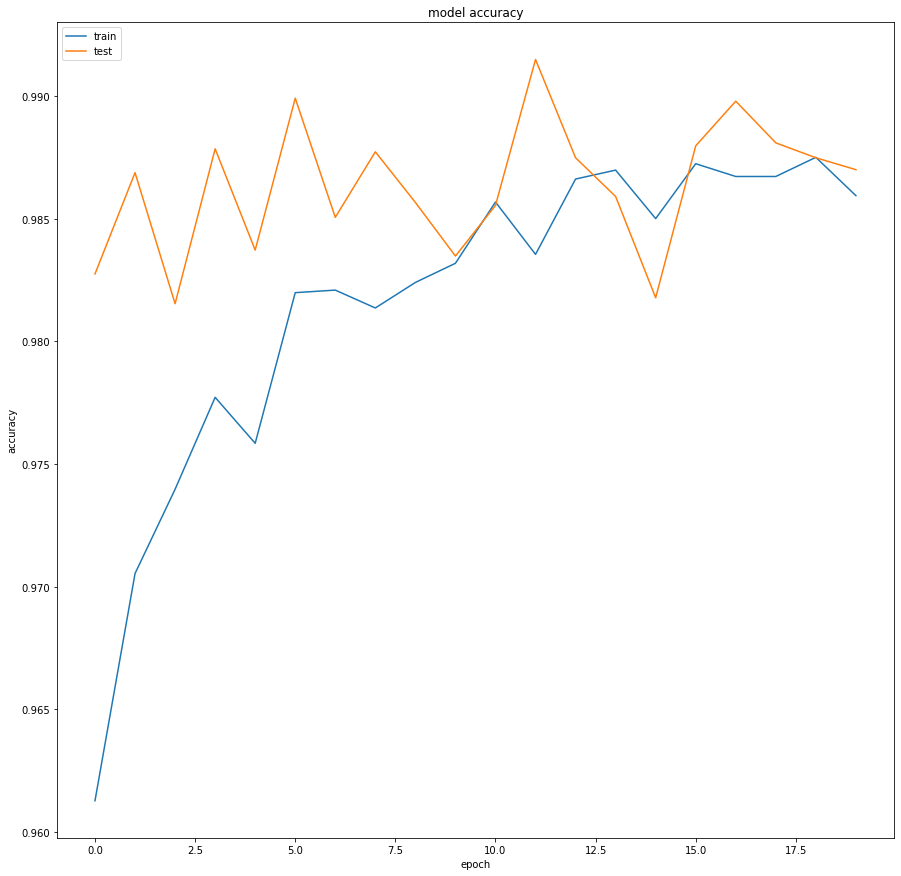

In [41]:
plt.figure(figsize=(15, 15))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [54]:
val_accuracy = np.array(history.history["val_accuracy"])

In [56]:
print("La meilleur performance est ", val_accuracy.max()*100 , '%')

La meilleur performance est  99.14986491203308 %


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


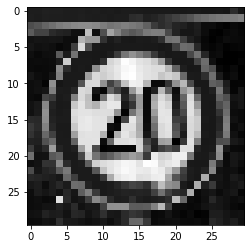

In [80]:
img = data[30]
plt.imshow(img , cmap='gray')
print(labels[30])
img = img.reshape(-1, 30, 30, 1)

In [78]:
classes[model.predict(img).argmax()]

'Speed limit (20km/h)'